In [1]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)


In [2]:
# Imports required libraries

# for data wrangling
import numpy as np
import pandas as pd
import re, datetime
import string

# for NLP / sentiment analysis
# import nltk
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('vader_lexicon')

# for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# for model building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler # for training set
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# for exporting cleaned data
import os
from os.path import join
from joblib import dump, load

# for local helper funtions
import helper_module

## Read in data

In [3]:
reviews_df = pd.read_csv("Reviews_cleanText_noSW_sageMakerLocal.csv")

In [4]:
# Ensure NAs have been removed
assert(reviews_df.isna().sum().sum() == 0)

In [120]:
%%time

X_train, X_test, y_train, y_test = train_test_split(reviews_df["cleaned_text"], 
                                                    reviews_df["Score_class"], 
                                                    test_size=0.2,
                                                    random_state=42)
ros = RandomOverSampler(random_state=42)
X_res_train, y_res_train = ros.fit_resample(X_train.array.reshape(-1, 1), y_train)

X_res_train = pd.Series(X_res_train[:,0])

print("%d items in training data, %d in test data" % (len(X_train), len(X_test)))

315241 items in training data, 78811 in test data
CPU times: user 193 ms, sys: 4.01 ms, total: 197 ms
Wall time: 196 ms


In [5]:
count_vect = CountVectorizer(min_df = 1, ngram_range = (1, 2))
count_vect = count_vect.fit(X_res_train)
X_train_counts = count_vect.transform(X_res_train)

tfidf_transformer = TfidfTransformer()
tfidf_transformer = tfidf_transformer.fit(X_train_counts)
X_train_tfidf = tfidf_transformer.transform(X_train_counts)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:1671: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


In [121]:
X_new_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

## Cross validation hyperparameter tuning for Logistic Regression

In [6]:
param_dict = {'C': [0.01, 0.1, 1, 10, 25, 100]}
clf = LogisticRegression(penalty='l2', max_iter=500)
clf_cv = GridSearchCV(clf, param_grid=param_dict,
                      scoring=['accuracy', 'f1', 'roc_auc', 'recall'],
                      refit='roc_auc',
                      verbose = 2,
                      return_train_score=True)
clf_cv.fit(X_train_tfidf, y_res_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .............................................C=0.01; total time=  16.1s
[CV] END .............................................C=0.01; total time=  14.9s
[CV] END .............................................C=0.01; total time=  14.2s
[CV] END .............................................C=0.01; total time=  13.6s
[CV] END .............................................C=0.01; total time=  14.6s
[CV] END ..............................................C=0.1; total time=  27.9s
[CV] END ..............................................C=0.1; total time=  25.6s
[CV] END ..............................................C=0.1; total time=  26.6s
[CV] END ..............................................C=0.1; total time=  24.8s
[CV] END ..............................................C=0.1; total time=  25.1s
[CV] END ................................................C=1; total time= 1.5min
[CV] END ........................................

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................................C=10; total time= 6.8min
[CV] END ...............................................C=10; total time= 4.4min
[CV] END ...............................................C=25; total time= 5.8min
[CV] END ...............................................C=25; total time= 6.2min
[CV] END ...............................................C=25; total time= 7.0min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............................................C=25; total time= 6.9min
[CV] END ...............................................C=25; total time= 5.9min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=100; total time= 7.0min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=100; total time= 6.9min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=100; total time= 6.9min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=100; total time= 6.4min
[CV] END ..............................................C=100; total time= 5.7min


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.01, 0.1, 1, 10, 25, 100]}, refit='roc_auc',
             return_train_score=True,
             scoring=['accuracy', 'f1', 'roc_auc', 'recall'], verbose=2)

In [8]:
clf_cv_results = pd.DataFrame(clf_cv.cv_results_)

In [9]:
results_iteration = 2

In [10]:
clf_cv_results.to_csv(f'st-logreg-cvResults0{results_iteration}.csv', index=False, header=True)

['mean_test_roc_auc', 'std_test_roc_auc', 'mean_train_roc_auc', 'std_train_roc_auc']
0 C
         mean_train_roc_auc  std_train_roc_auc
param_C                                       
0.01               0.900636                0.0
0.10               0.938598                0.0
1.00               0.983964                0.0
10.00              0.999919                0.0
25.00              0.999997                0.0
100.00             1.000000                0.0


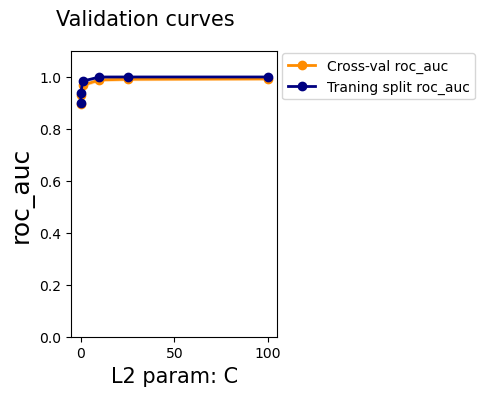

In [94]:
metric = 'roc_auc'
p1 = helper_module.metric_cv_plot_singleParam(clf_cv_results, metric, param_dict)
p1.savefig(f'logreg_cv_{metric}_scores.png', bbox_inches = "tight")

['mean_test_accuracy', 'std_test_accuracy', 'mean_train_accuracy', 'std_train_accuracy']
0 C
         mean_train_accuracy  std_train_accuracy
param_C                                         
0.01                0.822462                 0.0
0.10                0.867705                 0.0
1.00                0.942146                 0.0
10.00               0.997076                 0.0
25.00               0.999750                 0.0
100.00              0.999899                 0.0


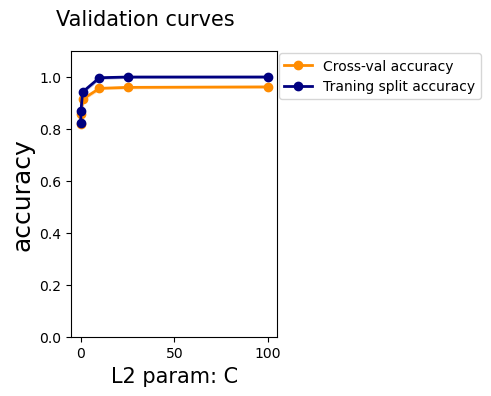

In [97]:
metric = 'accuracy'
p1 = helper_module.metric_cv_plot_singleParam(clf_cv_results, metric, param_dict)
p1.savefig(f'logreg_cv_{metric}_scores.png', bbox_inches = "tight")

['mean_test_recall', 'std_test_recall', 'mean_train_recall', 'std_train_recall']
0 C
         mean_train_recall  std_train_recall
param_C                                     
0.01              0.807093               0.0
0.10              0.856664               0.0
1.00              0.928982               0.0
10.00             0.995514               0.0
25.00             0.999626               0.0
100.00            0.999831               0.0


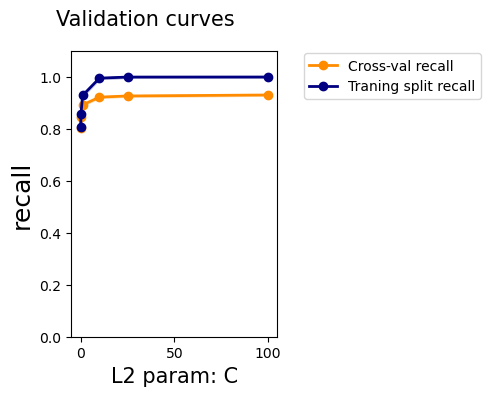

In [98]:
metric = 'recall'
p1 = helper_module.metric_cv_plot_singleParam(clf_cv_results, metric, param_dict)
p1.savefig(f'logreg_cv_{metric}_scores.png', bbox_inches = "tight")

['mean_test_f1', 'std_test_f1', 'mean_train_f1', 'std_train_f1']
0 C
         mean_train_f1  std_train_f1
param_C                             
0.01          0.819691           0.0
0.10          0.866228           0.0
1.00          0.941374           0.0
10.00         0.997072           0.0
25.00         0.999750           0.0
100.00        0.999899           0.0


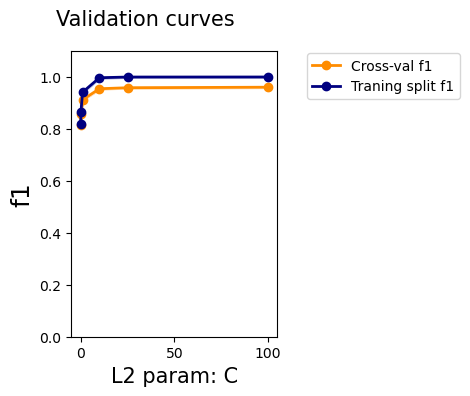

In [101]:
metric = 'f1'
p1 = helper_module.metric_cv_plot_singleParam(clf_cv_results, metric, param_dict)
p1.savefig(f'logreg_cv_{metric}_scores.png', bbox_inches = "tight")

## Refit training data with best params

In [122]:
clf = LogisticRegression(penalty='l2', C=10, max_iter=1000)
clf.fit(X_train_tfidf, y_res_train)
y_pred = clf.predict(X_test_tfidf)

In [123]:
auc, acc, f1, recall, cm = helper_module.model_eval(y_test, y_pred)

AUC Score: 0.8565338283249914
Accuracy Score: 0.8954841329256068
F1 Score: 0.9325284032732365
Recall: 0.9261181523843613
[[13652  3696]
 [ 4541 56922]]


In [124]:
name='LogisticRegression_best_noSW'
helper_module.add_model_scores_to_results(file_path = 'Model_results.csv', 
                            model_name = name,
                            datashift = 'none', with_sw = 0,
                            ROC_AUC = auc, accuracy = acc, 
                            f1 = f1, recall=recall, cm = cm, first_entry=False)

LogisticRegression_best_noSW saved successfully!


## Test data from shifted distributions

### 1. Review summaries: no stopwords

In [125]:
reviews_df.columns

Index(['Text', 'Summary', 'Score', 'cleaned_text', 'cleaned_summary',
       'Score_class', 'tokenized_reviews'],
      dtype='object')

Make the same train test split so that shifted distribution test sammples are completely unseen to training.

In [127]:
%%time

X_train, X_test, y_train, y_test = train_test_split(reviews_df["cleaned_summary"], 
                                                    reviews_df["Score_class"], 
                                                    test_size=0.2,
                                                    random_state=42)

CPU times: user 55.9 ms, sys: 0 ns, total: 55.9 ms
Wall time: 55 ms


In [128]:
X_new_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

In [129]:
y_pred = clf.predict(X_test_tfidf)

In [130]:
auc, acc, f1, recall, cm = helper_module.model_eval(y_test, y_pred)

AUC Score: 0.7697835551805743
Accuracy Score: 0.847229447665935
F1 Score: 0.9026472823713958
Recall: 0.908139856499032
[[10954  6394]
 [ 5646 55817]]


In [131]:
name='LogisticRegression_best_noSW_Summary'
helper_module.add_model_scores_to_results(file_path = 'Model_results.csv', 
                            model_name = name,
                            datashift = 'summary', with_sw = 0,
                            ROC_AUC = auc, accuracy = acc, 
                            f1 = f1, recall=recall, cm = cm, first_entry=False)

LogisticRegression_best_noSW_Summary saved successfully!


### 2. Random Dropout on cleaned summary text

In [132]:
%%time

X_train, X_test, y_train, y_test = train_test_split(reviews_df["cleaned_text"], 
                                                    reviews_df["Score_class"], 
                                                    test_size=0.2,
                                                    random_state=42)

CPU times: user 57.2 ms, sys: 0 ns, total: 57.2 ms
Wall time: 56 ms


In [172]:
def get_wordcount(sentence):
    return len(sentence.split())

In [174]:
X_test.apply(helper_module.get_wordcount).mean()

39.721764728273975

In [166]:
X_test_dropout = X_test.apply(helper_module.random_dropout, p=0.5, random_state=42)

In [175]:
X_test_dropout.apply(helper_module.get_wordcount).mean()

20.83643146261309

In [167]:
X_new_counts = count_vect.transform(X_test_dropout)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

In [168]:
y_pred = clf.predict(X_test_tfidf)

In [169]:
auc, acc, f1, recall, cm = helper_module.model_eval(y_test, y_pred)

AUC Score: 0.7940382805687668
Accuracy Score: 0.8452119627970714
F1 Score: 0.8992192986079557
Recall: 0.8854595447667702
[[12189  5159]
 [ 7040 54423]]


In [176]:
name='LogisticRegression_best_noSW_Droppout0.5'
helper_module.add_model_scores_to_results(file_path = 'Model_results.csv', 
                            model_name = name,
                            datashift = 'dropout_0.5', with_sw = 0,
                            ROC_AUC = auc, accuracy = acc, 
                            f1 = f1, recall=recall, cm = cm, first_entry=False)

LogisticRegression_best_noSW_Droppout0.5 saved successfully!


### 3. Cleaned reviews: with Stopwords

In [177]:
reviews_sw_df = pd.read_csv('Reviews_cleanText_SW_sageMakerLocal.csv')
reviews_sw_df.head()

,Unnamed: 0,Text,Summary,Score,cleaned_text,cleaned_summary,Score_class
0,0,I have bought several of the Vitality canned d...,Good Quality Dog Food,5,i have buy several of the vitality can dog foo...,good quality dog food,1
1,1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,1,product arrive label as jumbo salt peanutsthe ...,not as advertise,-1
2,2,This is a confection that has been around a fe...,"""Delight"" says it all",4,this be a confection that have be around a few...,delight say it all,1
3,3,If you are looking for the secret ingredient i...,Cough Medicine,2,if you be look for the secret ingredient in ro...,cough medicine,-1
4,4,Great taffy at a great price. There was a wid...,Great taffy,5,great taffy at a great price there be a wide a...,great taffy,1


In [179]:
reviews_sw_df.dropna(inplace=True)

In [180]:
X_train, X_test, y_train, y_test = train_test_split(reviews_sw_df["cleaned_text"], 
                                                    reviews_sw_df["Score_class"], 
                                                    test_size=0.2,
                                                    random_state=42)

In [181]:
X_test.apply(helper_module.get_wordcount).mean()

80.25521380725058

In [182]:
X_new_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

In [183]:
y_pred = clf.predict(X_test_tfidf)

In [184]:
auc, acc, f1, recall, cm = helper_module.model_eval(y_test, y_pred)

AUC Score: 0.9217191274173085
Accuracy Score: 0.9273802438808201
F1 Score: 0.9524030840477712
Recall: 0.9318392204628502
[[15860  1538]
 [ 4197 57378]]


In [185]:
name='LogisticRegression_best_SW'
helper_module.add_model_scores_to_results(file_path = 'Model_results.csv', 
                            model_name = name,
                            datashift = 'stopwords', with_sw = 1,
                            ROC_AUC = auc, accuracy = acc, 
                            f1 = f1, recall=recall, cm = cm, first_entry=False)

LogisticRegression_best_SW saved successfully!


### 4. Summary with Stopwords

In [186]:
X_train, X_test, y_train, y_test = train_test_split(reviews_sw_df["cleaned_summary"], 
                                                    reviews_sw_df["Score_class"], 
                                                    test_size=0.2,
                                                    random_state=42)

In [187]:
X_test.apply(get_wordcount).mean()

4.083788130120421

In [188]:
X_new_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

In [189]:
y_pred = clf.predict(X_test_tfidf)

In [190]:
auc, acc, f1, recall, cm = helper_module.model_eval(y_test, y_pred)

AUC Score: 0.7700464326918262
Accuracy Score: 0.8462892380940321
F1 Score: 0.9019110338976203
Recall: 0.9063418595209095
[[11026  6372]
 [ 5767 55808]]


In [191]:
name='LogisticRegression_best_Summary+SW'
helper_module.add_model_scores_to_results(file_path = 'Model_results.csv', 
                            model_name = name,
                            datashift = 'summary+stopwords', with_sw = 1,
                            ROC_AUC = auc, accuracy = acc, 
                            f1 = f1, recall=recall, cm = cm, first_entry=False)

LogisticRegression_best_Summary+SW saved successfully!


### 5. Dropout on review text with Stopwords

In [192]:
X_train, X_test, y_train, y_test = train_test_split(reviews_sw_df["cleaned_text"], 
                                                    reviews_sw_df["Score_class"], 
                                                    test_size=0.2,
                                                    random_state=42)

In [193]:
for i in [0.1, 0.25, 0.5]:
    X_test_dropout = X_test.apply(helper_module.random_dropout, p=i, random_state=42)
    X_new_counts = count_vect.transform(X_test_dropout)
    X_test_tfidf = tfidf_transformer.transform(X_new_counts)
    y_pred = clf.predict(X_test_tfidf)
    auc, acc, f1, recall, cm = helper_module.model_eval(y_test, y_pred)
    name=f'LogisticRegression_best_SW+Dropout{i}'
    helper_module.add_model_scores_to_results(file_path = 'Model_results.csv', 
                                model_name = name,
                                datashift = f'dropout_{i}', with_sw = 1,
                                ROC_AUC = auc, accuracy = acc, 
                                f1 = f1, recall=recall, cm = cm, first_entry=False)

AUC Score: 0.6212573348461005
Accuracy Score: 0.6842971648538108
F1 Score: 0.7837978459563988
Recall: 0.733950466910272
[[ 8848  8550]
 [16382 45193]]
LogisticRegression_best_SW+Dropout0.1 saved successfully!
AUC Score: 0.7600446973875268
Accuracy Score: 0.7947779620883086
F1 Score: 0.8620128902624878
Recall: 0.8221356069833536
[[12143  5255]
 [10952 50623]]
LogisticRegression_best_SW+Dropout0.25 saved successfully!
AUC Score: 0.8361112815455616
Accuracy Score: 0.8571283856507921
F1 Score: 0.9050867703592789
Recall: 0.8736825010150223
[[13893  3505]
 [ 7778 53797]]
LogisticRegression_best_SW+Dropout0.5 saved successfully!
